# Linear Regression 

Linear regression is a technique that measures the relationship between two variables. If we have an independent variable $X$, and a dependent outcome variable $Y$, linear regression allows us to determine which linear model $Y = \alpha + \beta X$ best explains the data.

Python's `statsmodels` library has a built-in linear fit function. Note that this will give a line of best fit; whether or not the relationship it shows is significant is for you to determine. The output will also have some statistics about the model, such as R-squared and the F value, which may help you quantify how good the fit actually is.

In [1]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

%matplotlib inline

## Retrieving Data 

First we need to get pricing data for our benchmark **(KSE 100)**. Data will be obtained from the CapitalStake.com API.

In [101]:
from urllib.request import Request, urlopen
import json
import pandas as pd

request = Request("http://capitalstake.com/market/graph/kse/year-to-date")
response = urlopen(request)
json_string = response.readall().decode('utf-8')
data = json.loads(json_string)
benchmark = pd.io.json.json_normalize(data)

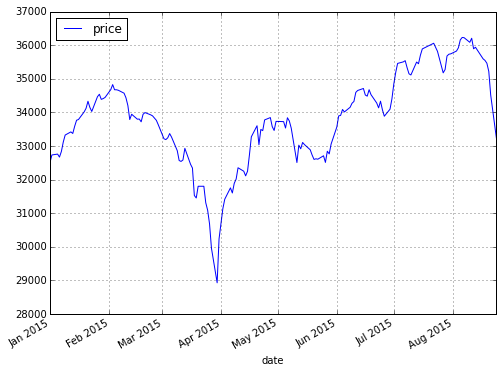

In [102]:
benchmark.date = pd.to_datetime(benchmark.date)

benchmark = benchmark.sort(['date'])
benchmark = benchmark.set_index('date')

benchmark.plot(figsize=(8,6))

Now we need the daily prices of our asset. This will be obtained from a CSV file containing all the assets listed in KSE. CSV contains the opening, closing, high, low values. We are only interested in `date` and `ldcp`.

We'll create a useable function to obtain certian asset against the Symbol.

In [103]:
asset_prices = pd.read_csv('data/2015.csv')

def get_asset(symbol):
    global asset_prices
    a = asset_prices[asset_prices.symbol == symbol][['date', 'ldcp']]
    a.loc[:,'date'] = pd.to_datetime(a.date)
    return a.set_index('date')

Lets retrieve our first asset **DGKC** for the comparison.

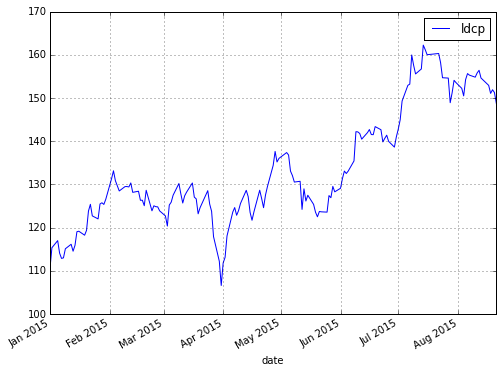

In [132]:
asset = get_asset('DGKC')

asset.plot(figsize=(8,6))

## Performing linear regression

First we'll define a function that performs linear regression and plots the results.

In [133]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

Let merge asset and benchmark dataframes so that both of the prices will map against the date. Then we will remove the values where we dont have asset price.

In [134]:
df_merged = benchmark.join(asset)
df_merged = df_merged[pd.notnull(df_merged['ldcp'])]
df_merged.head()

,price,ldcp
date,,
2015-01-01,32503.80,110.53
2015-01-02,32731.61,115.33
2015-01-05,32757.79,116.97
2015-01-06,32668.73,114.08
2015-01-07,32835.94,112.86


Now we are ready to perform regression, we'll take the percentage returns of both prices and apply them to the `linreg` function.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.112
Date:                Mon, 24 Aug 2015   Prob (F-statistic):             0.0251
Time:                        12:25:04   Log-Likelihood:                 391.90
No. Observations:                 157   AIC:                            -779.8
Df Residuals:                     155   BIC:                            -773.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0019      0.002      1.204      0.231        -0.001     0.005
x1             0.3869      0.171      2.261      0.025         0.049     0.725
==============================================================================
Omnibus:                        2.562   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.522
Skew:                          -0.040   Prob(JB):                        0.283
Kurtosis:                       3.616   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

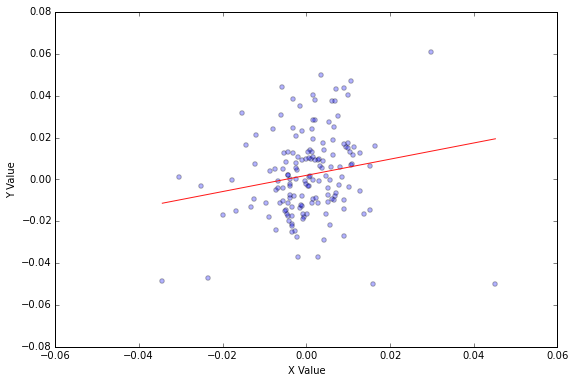

In [135]:
# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
asset_returns = df_merged.ldcp.pct_change()[1:]
benchmark_returns = df_merged.price.pct_change()[1:]

linreg(benchmark_returns.values, asset_returns.values)

Let use a different asset and compare it with out benchmark:

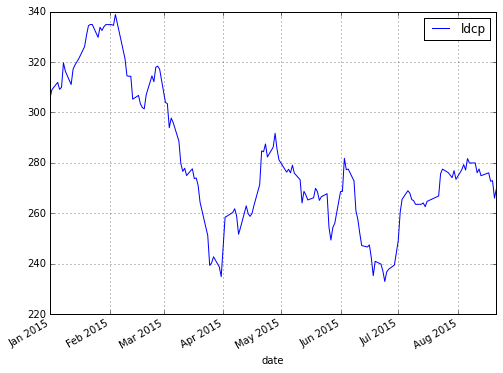

In [148]:
asset = get_asset('MCB')

asset.plot(figsize=(8,6))

In [149]:
df_merged = benchmark.join(asset)
df_merged = df_merged[pd.notnull(df_merged['ldcp'])]
df_merged.head()

,price,ldcp
date,,
2015-01-01,32503.80,305.65
2015-01-02,32731.61,308.98
2015-01-05,32757.79,311.90
2015-01-06,32668.73,309.13
2015-01-07,32835.94,309.95


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.473
Date:                Mon, 24 Aug 2015   Prob (F-statistic):             0.0643
Time:                        12:49:56   Log-Likelihood:                 396.29
No. Observations:                 157   AIC:                            -788.6
Df Residuals:                     155   BIC:                            -782.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.474      0.636        -0.004     0.002
x1             0.3101      0.166      1.863      0.064        -0.019     0.639
==============================================================================
Omnibus:                       25.770   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.796
Skew:                           0.638   Prob(JB):                     3.13e-15
Kurtosis:                       5.930   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

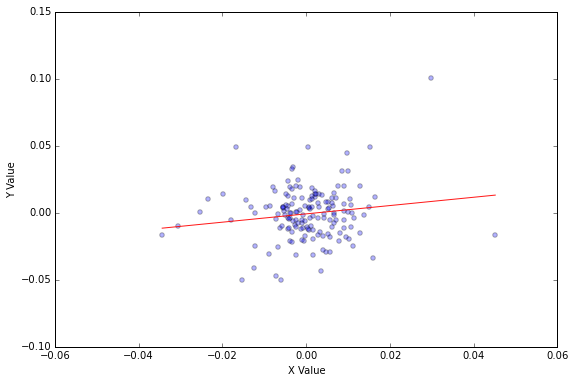

In [150]:
asset_returns = df_merged.ldcp.pct_change()[1:]
benchmark_returns = df_merged.price.pct_change()[1:]

linreg(benchmark_returns.values, asset_returns.values)